# Predicting Insurance Costs

For this project, we'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we're interested in how these different characteristics relate to the total medical cost. For this project, we want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population. 

## Exploring the data

Let's inform ourselves about the data first.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox

insurance = pd.read_csv('insurance.csv')
print(insurance.info())
print('\n')
print(insurance.head())
print('\n')

# Descriptive statistics 
num_vars = insurance.columns[insurance.dtypes != 'object']
print("Numerical vars descriptives:")
print(insurance[num_vars].describe())
print('\n')
cat_vars = insurance.columns[insurance.dtypes == 'object']
print("Categorical vars descriptives:")
print(insurance[cat_vars].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


Numerical vars descriptives:
               age          bmi     children       charges

## Plotting distributions and correlations

It looks as if there are no recorded missing values in the data. Let's check the distributions of the variables and look at the correlations. For that, we willl ceate dummy-variables for the categorical variables.

In [6]:
# Code categorical variables as dummies

insurance_updated = pd.get_dummies(data=insurance, columns=['sex', 'smoker', 'region'], drop_first=False, dtype='int')

                       age       bmi  children   charges  sex_female  \
age               1.000000  0.109272  0.042469  0.299008    0.020856   
bmi               0.109272  1.000000  0.012759  0.198341   -0.046371   
children          0.042469  0.012759  1.000000  0.067998   -0.017163   
charges           0.299008  0.198341  0.067998  1.000000   -0.057292   
sex_female        0.020856 -0.046371 -0.017163 -0.057292    1.000000   
sex_male         -0.020856  0.046371  0.017163  0.057292   -1.000000   
smoker_no         0.025019 -0.003750 -0.007673 -0.787251    0.076185   
smoker_yes       -0.025019  0.003750  0.007673  0.787251   -0.076185   
region_northeast  0.002475 -0.138156 -0.022808  0.006349    0.002425   
region_northwest -0.000407 -0.135996  0.024806 -0.039905    0.011156   
region_southeast -0.011642  0.270025 -0.023066  0.073982   -0.017117   
region_southwest  0.010016 -0.006205  0.021914 -0.043210    0.004184   

                  sex_male  smoker_no  smoker_yes  region_north

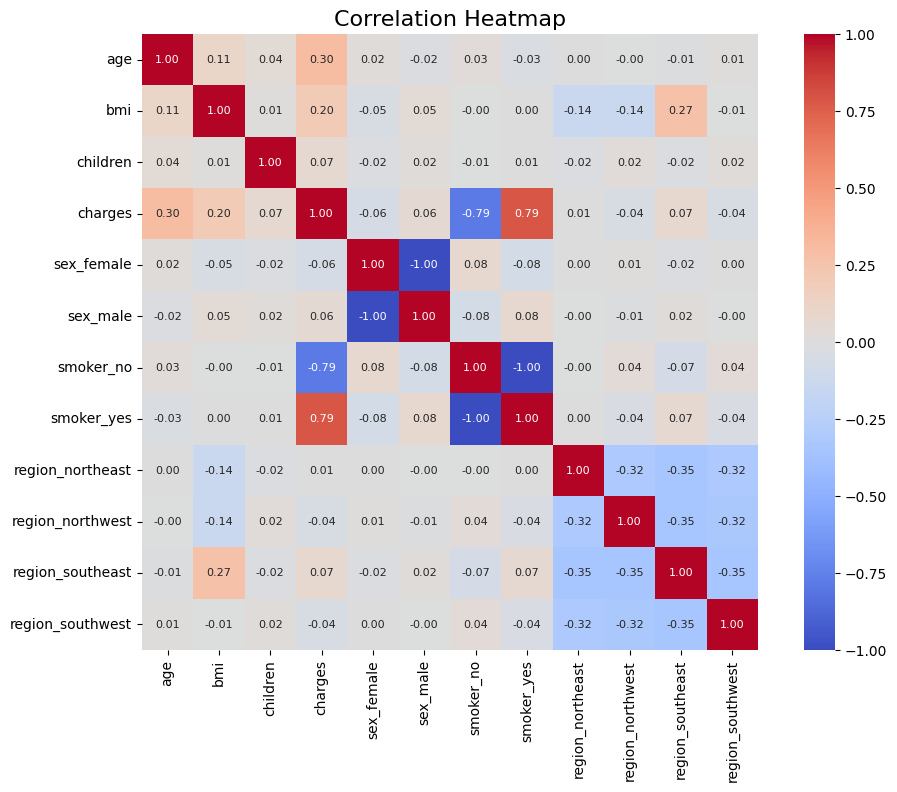

In [7]:
# Calculate correlations

correlations = insurance_updated.corr()
print(correlations)

# Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


Let's focus on the correlations with `charges`, our outcome variable (Individual medical costs billed by health insurance).

We find that `age`(r=.30), `bmi` (Body Mass Index, r=.20), and especially whether someone is a smoker (`smoker_yes`, r=.79) are highly correlated with the outcome variable. Additionally, there seem to be more older women (correlation between female and age, r=.30), and BMI seems somewhat more pronounced in some regions than in others. It might make sense to control for these potential confounders.

Let's quickly plot the variable distributions and frequency tables for the categorical variables.

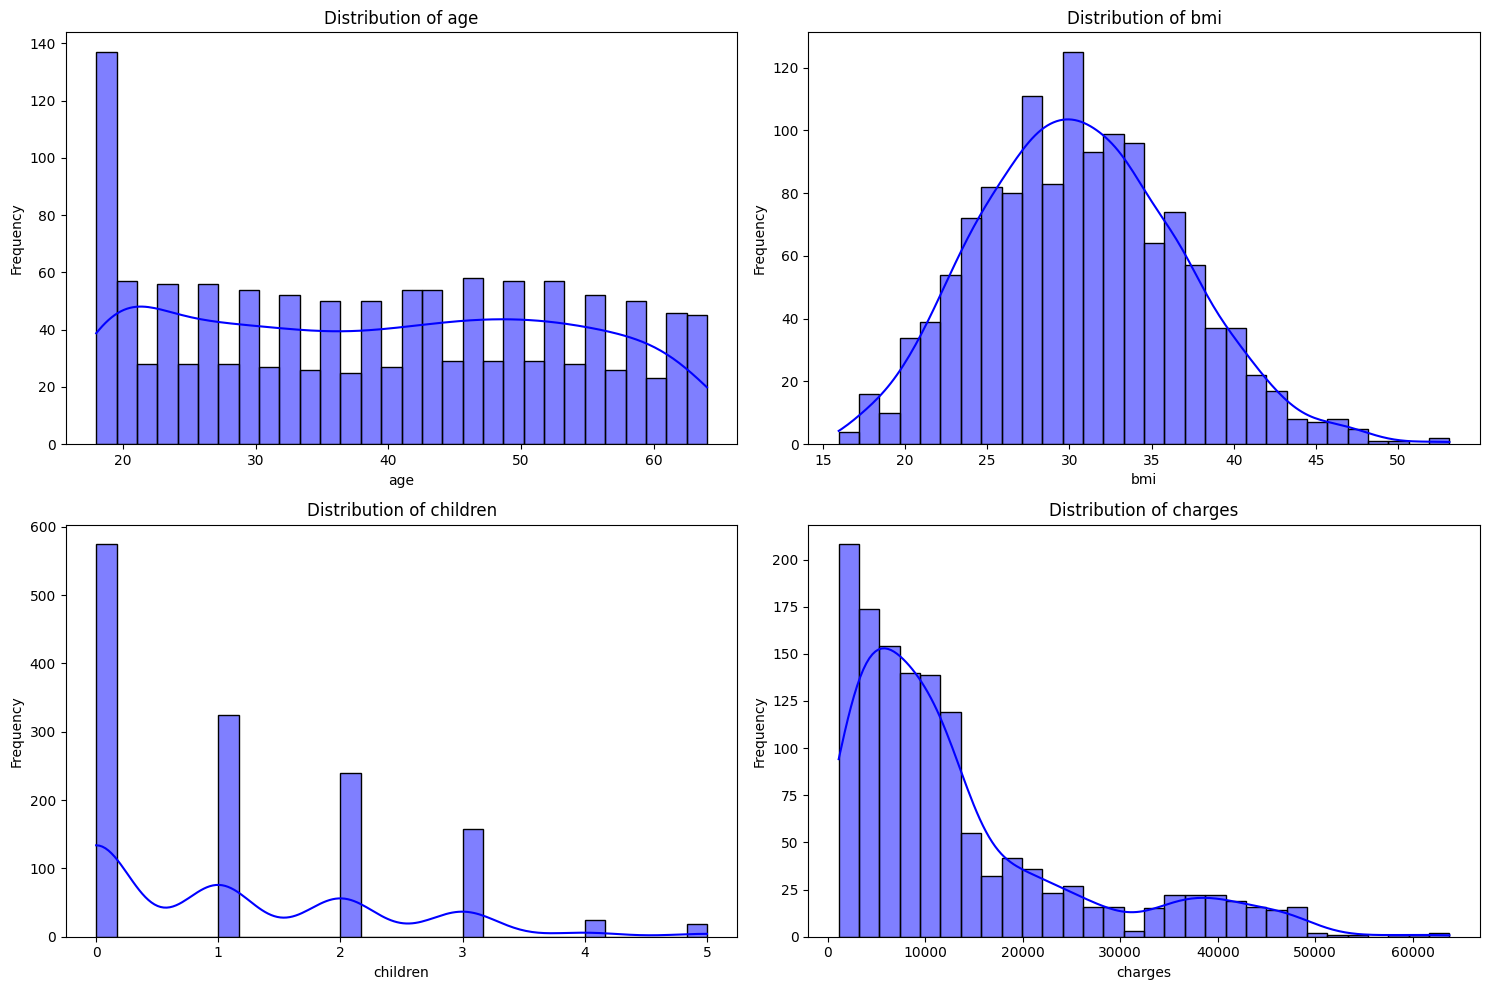

In [15]:
# Plot distributions of numerical variables

plt.figure(figsize=(15, 10))

for i, var in enumerate(num_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(insurance_updated[var], kde=True, color='blue', bins=30)
    plt.title(f'Distribution of {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Frequency tables of categorical variables

print(insurance['sex'].value_counts(normalize=True))
print('\n')
print(insurance['smoker'].value_counts(normalize=True))
print('\n')
print(insurance['region'].value_counts(normalize=True))

male      0.505232
female    0.494768
Name: sex, dtype: float64


no     0.795217
yes    0.204783
Name: smoker, dtype: float64


southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: region, dtype: float64


The inspection of the distributions shows some unexpected results. For instance, the age distribution seems almost equally distributed, except for the youngest age (18), whose share is disproportionally high. This might be related to the insurance policy (e.g. insuring teenage children with their parents) or a data error.

The BMI is normally distributed (with mean 30.66). Hence we don't see any overrepresentation of any particular BMI values.

On average, the insured person has 1.09 children, but the distribution is strongly leaning towards persons reporting having no children.

The distribution of the `charges` variable is positive skewed, with most insurance members paying low charges but the distribution has a long tail of cases, that are being charged very high insurance fees. On average the charges are 13,270 USD. It might make sense to transfrom this variable later using the log-transform, as it seems fairly skewed (see below).# Inspecting the coefficients

model.fit(X_train, y_train)
intercept = model.intercept_
coefficients = model.coef_

# Create a regression summary table
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=['Intercept', 'age', 'bmi', 'sex_female', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'])

print(regression_table)

With regard to the categorical variablesm we observe that the dataset is balnced by sex and region. However, we see that the majority (79.5%) of insurance members are non-smokers, and only 20% smoke.

Based on these initial observations it seems that the main predictors of `charges`that we should include in our model are `smoker_yes`, `age`, `bmi`, `sex_female`. BMI and being a smoker play the biggest role. We saw that age correlates with charges, but women tend to be older. Therefore, we will control for sex. As BMI is correlated with region, we will also include region dummies. Just the `children` variable does not seem to be correlated with either the outcome or any other covariate, We therefore omit this variable rom our model.

## Dividing the data into training and test sets

We will divide the data into 80% training and 20% test data to asses the predictive ability of the model. We will also drop the `children`variable, and the reference categories for the dummy variables. Reference for `sex`is male, for `smoker`is the group of non-smokers, for `region`northeast.

In [17]:
# Prepare training and test data, dropping children variable

X = insurance_updated.drop(axis=1, columns=['charges', 'children', 'sex_male' , 'smoker_no', 'region_northeast'])
y = insurance_updated['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

## Building the model

Now that we've divided up the data into both a training and test set, we're ready to build our predictive linear model. We will then inspect the model coefficients and goodness-of-fit measures.

In [19]:
# Building the model

model = LinearRegression()
fitted_model = model.fit(X_train, y_train)

In [20]:
# Inspecting the coefficients

model.fit(X_train, y_train)
intercept = model.intercept_
coefficients = model.coef_

# Create a regression summary table
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=['Intercept', 'age', 'bmi', 'sex_female', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'])

print(regression_table)

                   Coefficient
Intercept        -10952.365939
age                 246.387473
bmi                 340.711806
sex_female           81.840996
smoker_yes        23994.078573
region_northwest   -521.441370
region_southeast  -1266.000795
region_southwest  -1429.978759


In [21]:
# Assessing the model fit (training data)

train_predictions = model.predict(X_train)

train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)

R2_train = r2_score(y_train, train_predictions)

print('Train MSE:', train_mse)
print('Train RMSE:', train_rmse)
print('Train R2:', R2_train)

Train MSE: 37448771.99476839
Train RMSE: 6119.540178376836
Train R2: 0.7466737169857369


Looking at the model results, we find that the intercept of -10952.37 is not meaningfully interpretable given the coding of the predictors variables. Hypothetically it would show that a person of 0 years of age, with a BMI of zero, who is male and a non-smoker living in the Northeast would be charged -10952.37 USD per year, which is of course nonsensical.

We can however interpret the slopes. An increase of `age`by one year will be associated with incrased costs of on average 246.39 USD. Each additional BMI point is associated with increased costs of 340.71 USD. Women are being charged 81.84 USD on average more than men, holding all other covariates at constant. By far the biggest absolute efffect is observed for smokers. A smoker will on average have their insurance costs increased by 23994.08 USD in comparison to non-smokers. Furthermore, the chargest are highest in the Northeast region, as all other region dummies have a negative sign, indicating less costs for people from these regions in comparison to the reference group. (People in the South benefit from lower costs incomparison to people from the North.)

At least on the training data our model is performing reasonably well. The RMSE of 6119.54 indicates that on average we will misestimate the real charges by 6119.54 USD. But the R-squared shows that we are able to statistically explain ca. 75% of the total variation in annual insurance charges based on our covariates. It will be interesting to see whether our model holds the same predictive power for the test dataset.

# Residual diagnostics

Let us check how well the linear regression assumptions are met and examine some residual diagnostics.

In [22]:
#  Calculating residuals

predictions = model.predict(X_train)
residuals = y_train - predictions

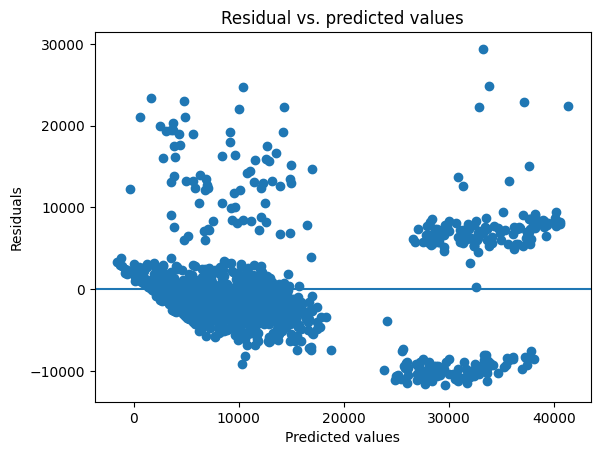

In [26]:
# Plotting predictions vs residuals

plt.scatter(x=predictions, y=residuals)
plt.title('Residual vs. predicted values', fontsize=12)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y=0) 
plt.show()

The residual plot does not show any particular upward or downward trend of the residuals. It also doesn't show a non-linear or curved pattern. However, it shows a strange form of clustering into roughly four clusters, where we systematically tend to misestimate the true values. We should try to adress this issue, potentially by running the model on transformed data. The variance of residuals does not seem to systematically change over the range of predictions. So apart from the clustering, the assmuptions seem to hold ok.

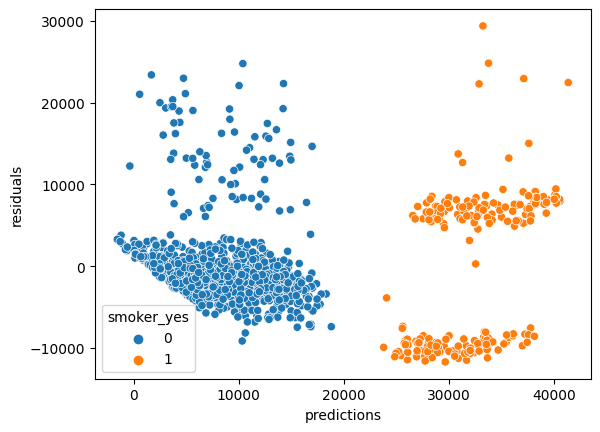

In [41]:
X_train['predictions'] = predictions
X_train['residuals'] = residuals

sns.scatterplot(data=X_train, y='residuals', x='predictions', hue='smoker_yes')
plt.show()

X_train=X_train.drop(columns=['predictions', 'residuals'])

The clustering on the horizontal axis can be explained by different predictions for smokers and non-smokers. However, it's not clear why we over- or underestimate the charges in both groups.

## Evaluating the model on the test data



In [42]:
# Assessing the model fit (test data)

test_predictions = model.predict(X_test)

test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

R2_test = r2_score(y_test, test_predictions)

print('Train MSE:', train_mse)
print('Train RMSE:', train_rmse)
print('Train R2:', R2_train)

print('Test MSE:', test_mse)
print('Test RMSE:', test_rmse)
print('Test R2:', R2_test)

Train MSE: 37448771.99476839
Train RMSE: 6119.540178376836
Train R2: 0.7466737169857369
Test MSE: 34685017.71206437
Test RMSE: 5889.398756415155
Test R2: 0.753409677393805


Comparing the fit measures of the training and test data shows that the MSE and RMSE in the test sample are actually lower than in the training sample. Therefore, our model predicts the actual insurance charges in the test data even slightly better than in the training data. Additionally, the R-squared shows that we explain the variation in our training and test data equally well,with approx. 75% of variation being explained by the covariates in the model.

However, the modelling steps that we implemented here can only be a first step. There still is a surprising amount of clustering in the data that so far we were not able to explain. The outcome variable is pretty skewed, and we should try to examine the results using log-transformed outcome data. Lastly, we observed a strong overrepresentation of 18-year-olds in our data. We might need to check if recalculating the mode without this age group changes anything in our results.

Overall the predictions of the model show that being a smoker is one of the strongest predictors of health costs, with age, BMI, or sex showing much weaker effects. Also the region of residence plays a role, and this might be related to different overall costs of living in an area. Hence, even though this model is reasonable good at prediction insurance costs, there is still room for improvement.